In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import ConvexHull

df = pd.read_parquet('process_2.parquet')# data จาก gems data process
data_points = df[['x', 'y']].values

In [2]:
df

,index,data_process,data_display,Keyword,Abstract,processed_documents_s,vector,x,y
0,0,two archeological sites discovered recently is...,id: Gemstone_1 Title: Pre-Columbian Gems and O...,Gemstone,Two archeological sites that were discovered r...,"[two, archeological, sites, discovered, recent...","[-0.0057970188, 0.055725425, -0.05079549, 0.02...",-0.732679,2.172171
1,1,figure 1 five 10 jadeite samples levoketchpel ...,id: Gemstone_2 Title: Ornamental Jadeites from...,Gemstone,Figure 1. Five of the 10 jadeite samples from ...,"[figure, 1, five, 10, jadeite, samples, levoke...","[0.04978066, -0.031103676, -0.022980962, 0.039...",2.526106,5.257230
2,2,figure 1 single tourmaline fiber contains thre...,id: Gemstone_3 Title: Colored Stones and Pearl...,Gemstone,Figure 1. A single tourmaline fiber contains t...,"[figure, 1, single, tourmaline, fiber, contain...","[-0.010867849, -0.021513185, -0.045135252, 0.0...",2.571761,2.733680
3,4,figure 1 paisley earrings ca 1885 gilt silver ...,id: Gemstone_5 Title: Exhibition Review: Ornam...,Gemstone,Figure 1. Paisley earrings ca. 1885. Gilt silv...,"[figure, 1, paisley, earrings, ca, 1885, gilt,...","[0.040627435, 0.021101465, -0.02011571, 0.0733...",-2.286749,1.917985
4,5,noël adams hardcover 432 pp illus publ morgan ...,id: Gemstone_6 Title: Books: Bright Lights in ...,Gemstone,"By Noël Adams, hardcover, 432 pp., illus., pub...","[noël, adams, hardcover, 432, pp, illus, publ,...","[0.04624943, 0.077438615, -0.010378159, 0.0300...",-2.541490,2.226159
...,...,...,...,...,...,...,...,...,...
3208,110,800 shell remains late ottoman british mandate...,id: nacre_jewelry_155 Title: Button waste and ...,nacre_jewelry,Over 800 shell remains from the late Ottoman a...,"[800, shell, remains, late, ottoman, british, ...","[-0.03222377, 0.0019210138, 0.008421725, 0.039...",-1.965013,2.024704
3209,111,socalled new media technologies often referred...,id: nacre_jewelry_156 Title: The New Media Tec...,nacre_jewelry,The so-called new media technologies - often r...,"[socalled, new, media, technologies, often, re...","[0.037681274, -0.07877747, -0.04059247, -0.066...",-3.200164,0.147219
3210,113,past 15 years combination market forces enviro...,id: nacre_jewelry_158 Title: From Single Sourc...,nacre_jewelry,Over the past 15 years a combination of market...,"[past, 15, years, combination, market, forces,...","[0.026291138, 0.029178105, -0.043042358, 0.007...",-2.606993,4.774700
3211,114,cultured pearls human creations formed inserti...,"id: nacre_jewelry_161 Title: Yes, it turns: Ex...",nacre_jewelry,Cultured pearls are human creations formed by ...,"[cultured, pearls, human, creations, formed, i...","[0.021074304, -0.04415614, -0.007122643, -0.00...",-1.630545,6.786059


In [3]:
def calculate_bounds(xs, ys):
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)

    x_gap = x_max - x_min
    y_gap = y_max - y_min

    if x_gap > y_gap:
        x_min -= x_gap / 50
        x_max += x_gap / 50
        x_gap = x_max - x_min
        y_min -= (x_gap - y_gap) / 2
        y_max += (x_gap - y_gap) / 2
    else:
        y_min -= y_gap / 50
        y_max += y_gap / 50
        y_gap = y_max - y_min
        x_min -= (y_gap - x_gap) / 2
        x_max += (y_gap - x_gap) / 2

    return x_min, y_min, x_max, y_max
def calculate_kde(xs, ys, grid_size=800):
    x_min, y_min, x_max, y_max = calculate_bounds(xs, ys)
    grid_xs = np.linspace(x_min, x_max, grid_size)
    grid_ys = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(grid_xs, grid_ys)

    grid = np.vstack([xx.ravel(), yy.ravel()]).transpose()
    sample_size = len(xs)
    d = 2  # dimensions
    bw = (sample_size * (d + 2) / 4.)**(-1. / (d + 4))

    rng = np.random.RandomState(0)
    random_indexes = rng.choice(range(sample_size), min(sample_size, sample_size), replace=False)

    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(np.vstack([xs, ys]).T[random_indexes])
    log_density = np.exp(kde.score_samples(grid))
    grid_density = np.reshape(log_density, xx.shape)
    
    return xx, yy, grid_density, bw
def plot_clusters_with_kde(xs, ys, cluster_labels, grid_density, xx, yy, bw):
    x_min, y_min, x_max, y_max = calculate_bounds(xs, ys)
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'KDE on {grid_density.shape[0]} Grid of Samples (bw={bw:.1f})')
    cfset = ax.contourf(xx, yy, grid_density.round(4),
                        levels=np.linspace(0, np.max(grid_density), 20),
                        cmap='Blues', alpha=1)

    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    colors = plt.get_cmap('hsv')(np.linspace(0, 1.0, num_clusters))

    for i, cluster in enumerate(unique_clusters):
        cluster_points = np.vstack([xs, ys]).T[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=colors[i])
        
        centroid_x = np.mean(cluster_points[:, 0])
        centroid_y = np.mean(cluster_points[:, 1])
        plt.scatter(centroid_x, centroid_y, color='white', marker='x', s=50, linewidths=2)
        
        if len(cluster_points) > 2:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend()
    plt.show()
def get_unique_terms_per_cluster(df, num_clusters, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
    X = vectorizer.fit_transform(df['data_process'])
    terms = vectorizer.get_feature_names_out()
    cluster_mean_tfidf = {}

    for cluster in range(num_clusters):
        cluster_texts = X[df['cluster'] == cluster]
        cluster_mean_tfidf[cluster] = np.asarray(cluster_texts.mean(axis=0)).flatten()

    unique_terms_per_cluster = {}
    for cluster in range(num_clusters):
        mean_tfidf = cluster_mean_tfidf[cluster]
        top_terms_idx = mean_tfidf.argsort()[-top_n*100:][::-1]
        top_terms = [terms[idx] for idx in top_terms_idx]

        other_clusters_mean_tfidf = np.zeros_like(mean_tfidf)
        for other_cluster in range(num_clusters):
            if other_cluster != cluster:
                other_clusters_mean_tfidf += cluster_mean_tfidf[other_cluster]
        
        other_clusters_mean_tfidf /= (num_clusters - 1)
        other_clusters_terms_idx = other_clusters_mean_tfidf.argsort()[-top_n*100:][::-1]
        other_clusters_terms = set(terms[idx] for idx in other_clusters_terms_idx)

        unique_terms = [term for term in top_terms if term not in other_clusters_terms]
        unique_terms_per_cluster[cluster] = unique_terms[:top_n]
    
    return unique_terms_per_cluster


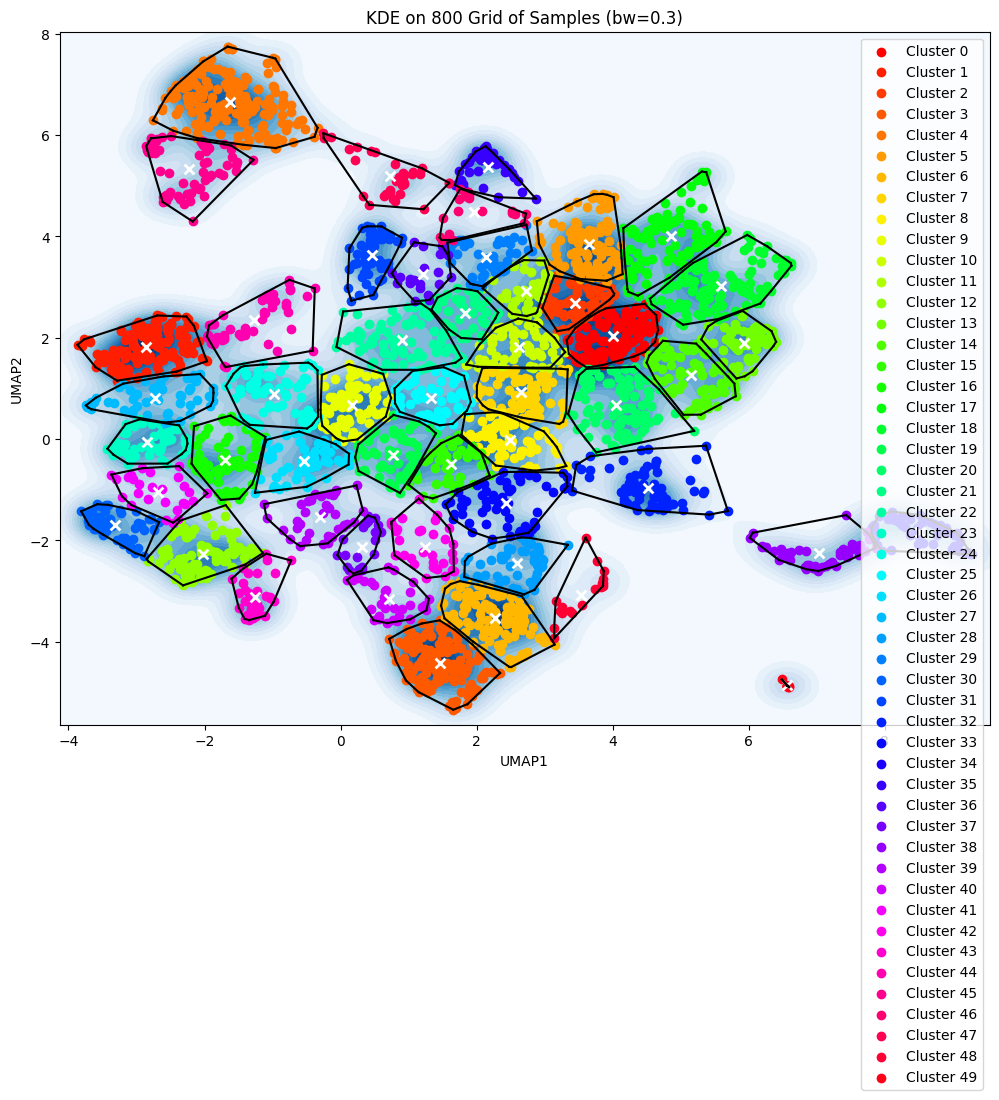

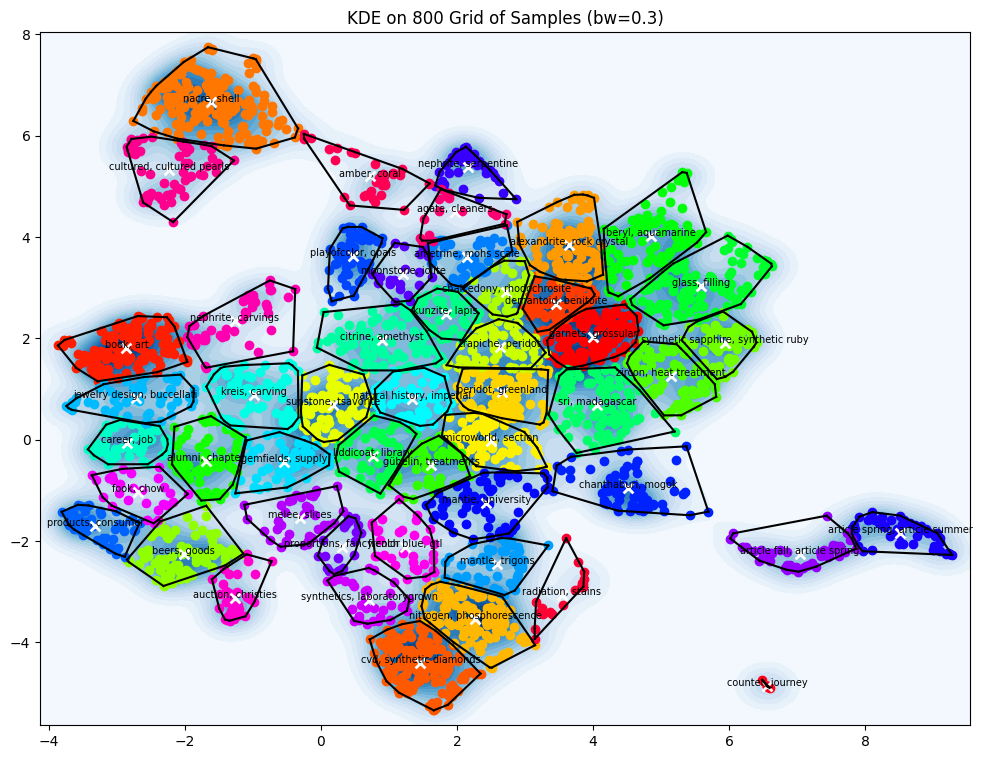

In [4]:
# ข้อมูลต้นฉบับ
xs = df['x'].to_numpy()
ys = df['y'].to_numpy()

# การคำนวณ KDE
xx, yy, grid_density, bw = calculate_kde(xs, ys)

# MeanShift clustering
bandwidth = 0.7
#bandwidth = (n * (d + 2) / 4.)**(-1. / (d + 4))
ms = MeanShift(bandwidth=bandwidth)
ms.fit(data_points)
cluster_labels = ms.labels_
df['cluster'] = cluster_labels
plot_clusters_with_kde(xs, ys, cluster_labels, grid_density, xx, yy, bw)
unique_terms_per_cluster = get_unique_terms_per_cluster(df, len(np.unique(cluster_labels)), top_n=5)

fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
ax.set_xlim(calculate_bounds(xs, ys)[0], calculate_bounds(xs, ys)[2])
ax.set_ylim(calculate_bounds(xs, ys)[1], calculate_bounds(xs, ys)[3])
ax.set_title(f'KDE on {grid_density.shape[0]} Grid of Samples (bw={bw:.1f})')
cfset = ax.contourf(xx, yy, grid_density.round(4),
                    levels=np.linspace(0, np.max(grid_density), 20),
                    cmap='Blues', alpha=1)
embedding = np.vstack([xs, ys]).T
unique_clusters = np.unique(cluster_labels)
num_clusters = len(unique_clusters)
colors = plt.get_cmap('hsv')(np.linspace(0, 1.0, num_clusters))

for i, cluster in enumerate(unique_clusters):
    cluster_points = embedding[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=colors[i])
    centroid_x = np.mean(cluster_points[:, 0])
    centroid_y = np.mean(cluster_points[:, 1])
    plt.scatter(centroid_x, centroid_y, color='white', marker='x', s=50, linewidths=2)
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')

for cluster in unique_clusters:
    cluster_points = embedding[cluster_labels == cluster]
    centroid = cluster_points.mean(axis=0)
    top_keywords = ', '.join(unique_terms_per_cluster[cluster][:2])  
    plt.annotate(top_keywords, centroid, fontsize=7, ha='center')

plt.show()


In [5]:
for cluster, terms in unique_terms_per_cluster.items():
    print(f"Cluster {cluster}: {terms}")

Cluster 0: ['garnets', 'grossular', 'andradite', 'demantoid', 'pyrope']
Cluster 1: ['book', 'art', 'rings', 'jewels', 'silver']
Cluster 2: ['demantoid', 'benitoite', 'scapolite', 'rhodonite', 'raman spectroscopy']
Cluster 3: ['cvd', 'synthetic diamonds', 'synthetic diamond', 'hpht', 'cvd synthetic']
Cluster 4: ['nacre', 'shell', 'cultured pearls', 'bead', 'freshwater']
Cluster 5: ['alexandrite', 'rock crystal', 'crystal quartz', 'rock crystal quartz', 'fluorite']
Cluster 6: ['nitrogen', 'phosphorescence', 'defects', 'cloud', 'band']
Cluster 7: ['peridot', 'greenland', 'university', 'volcanic', 'localities']
Cluster 8: ['microworld', 'section', 'coauthors', 'photomicrography', 'yogo']
Cluster 9: ['sunstone', 'tsavorite', 'montana', 'potentate', 'oregon']
Cluster 10: ['trapiche', 'peridot', 'pegmatites', 'demantoid', 'pegmatite']
Cluster 11: ['chalcedony', 'rhodochrosite', 'larimar', 'wavellite', 'copper']
Cluster 12: ['beers', 'goods', 'alrosa', 'billion', 'dealers']
Cluster 13: ['synth